This file is used to access image cutouts using the getcutout method. 

It uses the catalogues and images from the download_data.ipynb file. 

Much of the first half is similar to the download_data.ipynb file. The files were separated in order to cutdown execution times when the getcutout method is used. 

In [1]:
# packages needed to for file management,
# downloading and unpacking compressed catalogs.

from urllib3 import PoolManager


# basic packages for data handling and plotting
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import random

from astropy.io import fits
from astropy.table import Table

from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats

from scipy.constants import c as speed_of_light

# we download a file with multiple helpfull methods from the same git repository.
# These functions are well documented to facilitate further reading.
helper_func_url = 'https://raw.githubusercontent.com/DanielMaschmann/PHANGS_HST_star_cluster/main/helper_func.py'
# Download file. This will save them in the working directory.
http = PoolManager()
http_request_object = http.request('GET', helper_func_url, preload_content=False)
with open('helper_func.py', 'wb') as out:
    while True:
        data = http_request_object.read()
        if not data:
            break
        out.write(data)

!pip install dust_extinction

# in case of updates
%load_ext autoreload
%autoreload 2
import importlib
import helper_func as helper_func
mylibrary = importlib.reload(helper_func)

In [2]:
# we use NGC ngc1097 as an example
galaxy_name = 'ngc1097'

In [3]:
# some galaxies have HST image mosaics. Therefore the file names can change!
mosaic_flag = True
if mosaic_flag:
  bundle_file_name = galaxy_name + 'mosaic'
else:
  bundle_file_name = galaxy_name

Reads coordinates from fits file for NGC1097. Fits file is preprocessed to filter blank entries. Class labels above
class 4 are modified to 4 in order to group together all noise images.

In [4]:
fits_table = Table.read('../data/candidate_table_%s.fits' % galaxy_name)

In [5]:
filtered_table = fits_table[~fits_table['PHANGS_CLUSTER_CLASS_HUMAN'].mask] 
filtered_table.write("../data/valid_detections.fits", overwrite=True)

filtered_table['PHANGS_CLUSTER_CLASS_HUMAN'] = [
    min(value, 4) for value in filtered_table['PHANGS_CLUSTER_CLASS_HUMAN']
]
filtered_table.write("../data/filtered_file.fits", overwrite=True)

In [6]:
# get all data we need for the following examples
# coordinates
ra_hum_cl1234, dec_hum_cl1234 = filtered_table['PHANGS_RA'], filtered_table['PHANGS_DEC']

# morphological classification
class_human_hum_cl1234 = filtered_table['PHANGS_CLUSTER_CLASS_HUMAN']

In [7]:
# load the downloaded images
v_band_img_hdu = fits.open('%s/hlsp_phangs-hst_hst_wfc3-uvis_%s_f555w_v1_exp-drc-sci.fits' % (bundle_file_name, bundle_file_name))
v_band_img_header = v_band_img_hdu[0].header
v_band_img_data = v_band_img_hdu[0].data
v_band_img_wcs = WCS(v_band_img_header)

# change the image data from electron counts to units of Jy
# wavelength in angstrom
pivot_wavelength = v_band_img_header['PHOTPLAM']
# inverse sensitivity, ergs/cm2/Ang/electron
sensitivity = v_band_img_header['PHOTFLAM']
# speed of light in Angstrom/s
c = speed_of_light * 1e10
# change the conversion facto to get erg s−1 cm−2 Hz−1
f_nu = sensitivity * pivot_wavelength ** 2 / c
# change to get Jy
conversion_factor = f_nu * 1e23
# apply the conversion factor to the data
v_band_img_data *= conversion_factor

# this is not used in this tutorial but for completeness here we will load the uncertainty maps
v_band_invers_var_hdu = fits.open('%s/hlsp_phangs-hst_hst_wfc3-uvis_%s_f555w_v1_err-drc-wht.fits' % (bundle_file_name, bundle_file_name))
v_band_invers_var_data = v_band_invers_var_hdu[0].data
# the uncertainties are stored as inverse variance so we need to convert them into the standard deviation.
v_band_err_data = 1 / np.sqrt(v_band_invers_var_data)
# and again we need to apply the conversion factor to these data
v_band_err_data *= conversion_factor



C:\Users\SEANM\AppData\Local\Temp\ipykernel_28624\3871222887.py:25: RuntimeWarning: divide by zero encountered in divide
  v_band_err_data = 1 / np.sqrt(v_band_invers_var_data)


Generates plot to visualize where all objects are located in larger galaxy image.

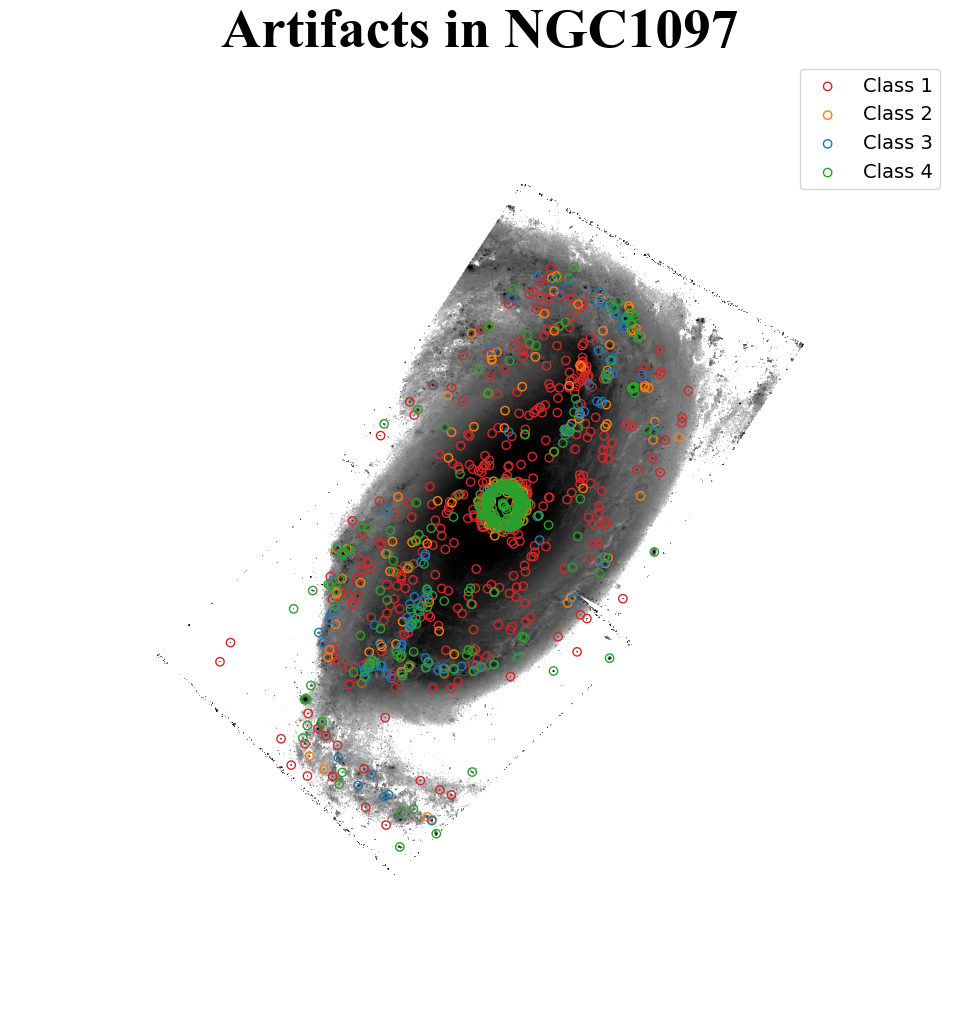

In [15]:
# in order to visualize the image we calculate some states of the image and calculate a strech.
mean, median, std = sigma_clipped_stats(v_band_img_data, sigma=3.0)
norm = LogNorm(0.1*std, median + 100*std)

figure = plt.figure(figsize=(10, 10))
ax_img = figure.add_axes([0.05, 0.05 , 0.94, 0.94], projection=v_band_img_wcs)
ax_img.imshow(v_band_img_data, cmap='Greys', norm=norm)

coords_hum_cl1234 = SkyCoord(ra=ra_hum_cl1234, dec=dec_hum_cl1234)
coords_hum_cl1234_pix = v_band_img_wcs.world_to_pixel(coords_hum_cl1234)

ax_img.scatter(coords_hum_cl1234_pix[0][class_human_hum_cl1234==1],
               coords_hum_cl1234_pix[1][class_human_hum_cl1234==1],
               facecolor='None', edgecolor='tab:red', linewidth=1,
               label='Class 1')
ax_img.scatter(coords_hum_cl1234_pix[0][class_human_hum_cl1234==2],
               coords_hum_cl1234_pix[1][class_human_hum_cl1234==2],
               facecolor='None', edgecolor='tab:orange', linewidth=1,
               label='Class 2')
ax_img.scatter(coords_hum_cl1234_pix[0][class_human_hum_cl1234==3],
               coords_hum_cl1234_pix[1][class_human_hum_cl1234==3],
               facecolor='None', edgecolor='tab:blue', linewidth=1,
               label='Class 3')
ax_img.scatter(coords_hum_cl1234_pix[0][class_human_hum_cl1234==4],
               coords_hum_cl1234_pix[1][class_human_hum_cl1234==4],
               facecolor='None', edgecolor='tab:green', linewidth=1,
               label='Class 4')

ax_img.axis("Off")
ax_img.set_title("Artifacts in NGC1097", fontsize=40, fontname="Times New Roman", fontweight="bold")
ax_img.legend(fontsize=14)


In [9]:
# cutout of random class 1, 2, 3, 4 clusters
mask_class1 = class_human_hum_cl1234 == 1
mask_class2 = class_human_hum_cl1234 == 2
mask_class3 = class_human_hum_cl1234 == 3
mask_class4 = class_human_hum_cl1234 == 4

coord_bright_class1 = coords_hum_cl1234[mask_class1][101]
coord_bright_class2 = coords_hum_cl1234[mask_class2][13]
coord_bright_class3 = coords_hum_cl1234[mask_class3][1]
coord_bright_class4 = coords_hum_cl1234[mask_class4][0]

cutout_bright_class1 = helper_func.get_img_cutout(img=v_band_img_data,
                                                  wcs=v_band_img_wcs,
                                                  coord=coord_bright_class1,
                                                  cutout_size=(2, 2))
cutout_bright_class2 = helper_func.get_img_cutout(img=v_band_img_data,
                                                  wcs=v_band_img_wcs,
                                                  coord=coord_bright_class2,
                                                  cutout_size=(2, 2))
cutout_bright_class3 = helper_func.get_img_cutout(img=v_band_img_data,
                                                  wcs=v_band_img_wcs,
                                                  coord=coord_bright_class3,
                                                  cutout_size=(2, 2))
cutout_bright_class4 = helper_func.get_img_cutout(img=v_band_img_data,
                                                  wcs=v_band_img_wcs,
                                                  coord=coord_bright_class4,
                                                  cutout_size=(2, 2))

Text(0.5, 1.0, 'Class 4: Other Objects or Noise\n')

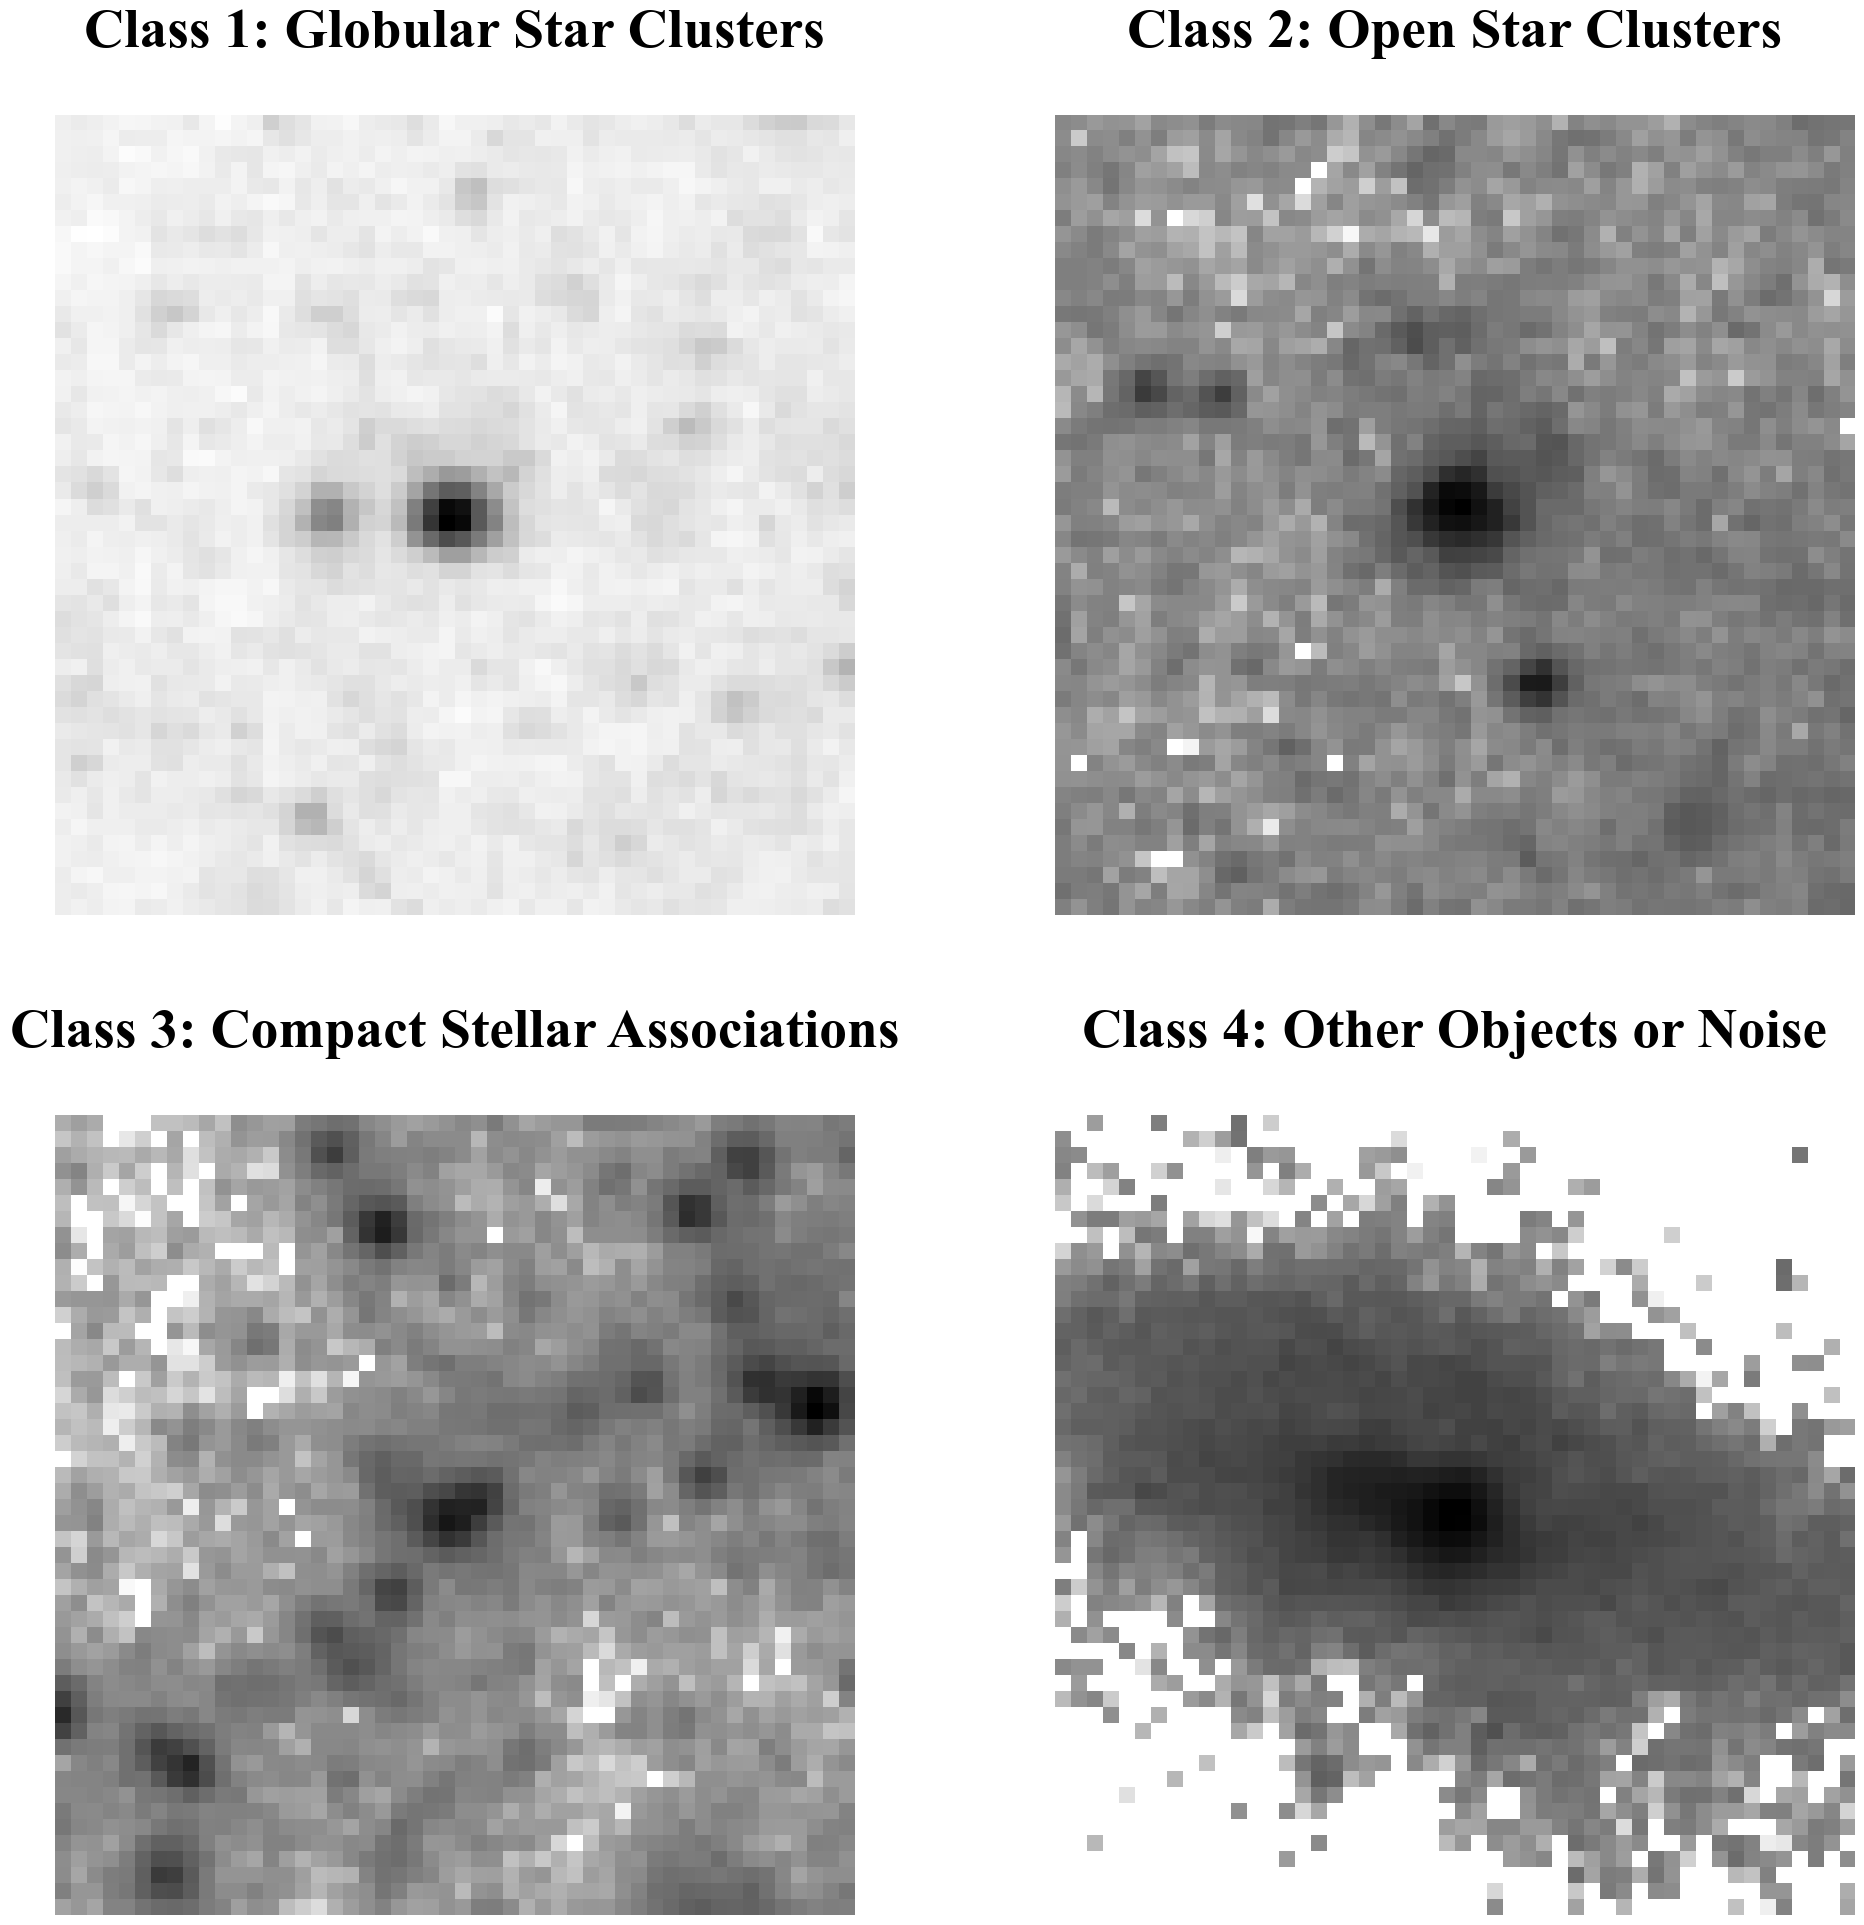

In [ ]:
figure_cutouts = plt.figure(figsize=(20, 20))  

# Adjusted positions for a 2x2 layout
ax_cutout_class1 = figure_cutouts.add_axes([0.05, 0.55, 0.4, 0.4], projection=cutout_bright_class1.wcs)
ax_cutout_class2 = figure_cutouts.add_axes([0.55, 0.55, 0.4, 0.4], projection=cutout_bright_class2.wcs)
ax_cutout_class3 = figure_cutouts.add_axes([0.05, 0.05, 0.4, 0.4], projection=cutout_bright_class3.wcs)
ax_cutout_class4 = figure_cutouts.add_axes([0.55, 0.05, 0.4, 0.4], projection=cutout_bright_class4.wcs)

# Display images with log normalization and grayscale colormap
ax_cutout_class1.imshow(cutout_bright_class1.data, norm=LogNorm(), cmap='Greys')
ax_cutout_class2.imshow(cutout_bright_class2.data, norm=LogNorm(), cmap='Greys')
ax_cutout_class3.imshow(cutout_bright_class3.data, norm=LogNorm(), cmap='Greys')
ax_cutout_class4.imshow(cutout_bright_class4.data, norm=LogNorm(), cmap='Greys')

# Remove axes
for ax in [ax_cutout_class1, ax_cutout_class2, ax_cutout_class3, ax_cutout_class4]:
    ax.axis("off")

# Set titles
ax_cutout_class1.set_title('Class 1: Globular Star Clusters\n', fontsize=40, fontname="Times New Roman", fontweight="bold")
ax_cutout_class2.set_title('Class 2: Open Star Clusters\n', fontsize=40, fontname="Times New Roman", fontweight="bold")
ax_cutout_class3.set_title('Class 3: Compact Stellar Associations\n', fontsize=40, fontname="Times New Roman", fontweight="bold")
ax_cutout_class4.set_title('Class 4: Other Objects or Noise\n', fontsize=40, fontname="Times New Roman", fontweight="bold")


In [11]:
# Get all coordinates for each class
coords_class1 = coords_hum_cl1234[mask_class1]
coords_class2 = coords_hum_cl1234[mask_class2]
coords_class3 = coords_hum_cl1234[mask_class3]
coords_class4 = coords_hum_cl1234[mask_class4]

Method to access images. Takes in size parameter and returns evenely distributed image data accross all classes.

In [12]:
def get_cutouts(size):

    # Determine available sizes
    available_class1 = len(coords_class1)
    available_class2 = len(coords_class2)
    available_class3 = len(coords_class3)
    available_class4 = len(coords_class4)
    
    total_available = available_class1 + available_class2 + available_class3 + available_class4
    size = min(size, total_available) 
    
    # Randomly distribute the requested size across classes
    class_sizes = random.choices(["class1", "class2", "class3", "class4"], k=size)
    count_class1 = class_sizes.count("class1")
    count_class2 = class_sizes.count("class2")
    count_class3 = class_sizes.count("class3")
    count_class4 = class_sizes.count("class4")
    
    # Extract random cutouts
    cutouts_class1 = [
        helper_func.get_img_cutout(img=v_band_img_data, wcs=v_band_img_wcs, coord=coords_class1[i], cutout_size=(2, 2))
        for i in random.sample(range(available_class1), min(count_class1, available_class1))
    ]
    
    cutouts_class2 = [
        helper_func.get_img_cutout(img=v_band_img_data, wcs=v_band_img_wcs, coord=coords_class2[i], cutout_size=(2, 2))
        for i in random.sample(range(available_class2), min(count_class2, available_class2))
    ]
    
    cutouts_class3 = [
        helper_func.get_img_cutout(img=v_band_img_data, wcs=v_band_img_wcs, coord=coords_class3[i], cutout_size=(2, 2))
        for i in random.sample(range(available_class3), min(count_class3, available_class3))
    ]

    cutouts_class4 = [
        helper_func.get_img_cutout(img=v_band_img_data, wcs=v_band_img_wcs, coord=coords_class4[i], cutout_size=(2, 2))
        for i in random.sample(range(available_class4), min(count_class4, available_class4))
    ]
    
    # Organize images and labels into a list
    dataset = []
    dataset.extend([(cutout.data, "class1") for cutout in cutouts_class1])
    dataset.extend([(cutout.data, "class2") for cutout in cutouts_class2])
    dataset.extend([(cutout.data, "class3") for cutout in cutouts_class3])
    dataset.extend([(cutout.data, "class4") for cutout in cutouts_class4])
    
    dataset

    return dataset